# Company Bankruptcy — Classification Task
Two algorithms: Logistic Regression and Random Forest Classifier. We address class imbalance via class weights.

In [1]:
from pathlib import Path
DATA_PATH = Path('../data')
CSV_FILE = DATA_PATH / 'classification.csv'
CSV_FILE

WindowsPath('../data/classification.csv')

In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (mean_squared_error, r2_score, classification_report,
                             confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.utils import compute_class_weight

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)


## Load & Inspect

In [3]:

df = pd.read_csv(CSV_FILE)
# Expect target 'Y' (0/1) and many numeric X1..X95
target = 'Bankrupt?'
y = df[target].astype(int)
X = df.drop(columns=[target])


# Identify numeric/categorical
numeric_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(exclude=np.number).columns.tolist()

print('Shape:', df.shape)
print('Positive rate:', y.mean().round(4))
df.head()


Shape: (6819, 96)
Positive rate: 0.0323


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,Contingent liabilities/Net worth,Operating profit/Paid-in capital,Net profit before tax/Paid-in capital,Inventory and accounts receivable/Net value,Total Asset Turnover,Accounts Receivable Turnover,Average Collection Days,Inventory Turnover Rate (times),Fixed Assets Turnover Frequency,Net Worth Turnover Rate (times),Revenue per person,Operating profit per person,Allocation rate per person,Working Capital to Total Assets,Quick Assets/Total Assets,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,0.006479,0.095885,0.137757,0.398036,0.086957,0.001814,0.003487,1.820926e-04,1.165007e-04,0.032903,0.034164,0.392913,0.037135,0.672775,0.166673,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,0.005835,0.093743,0.168962,0.397725,0.064468,0.001286,0.004917,9.360000e+09,7.190000e+08,0.025484,0.0068

## Train/Test Split & Preprocessing

In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])
categorical_transformer = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer([('num', numeric_transformer, numeric_cols),
                                  ('cat', categorical_transformer, categorical_cols)])


## Model 1 — Logistic Regression (with class_weight)

Best params: {'model__C': 0.1}
              precision    recall  f1-score   support

           0      0.992     0.886     0.936      1320
           1      0.188     0.795     0.304        44

    accuracy                          0.883      1364
   macro avg      0.590     0.841     0.620      1364
weighted avg      0.966     0.883     0.916      1364

ROC-AUC: 0.923


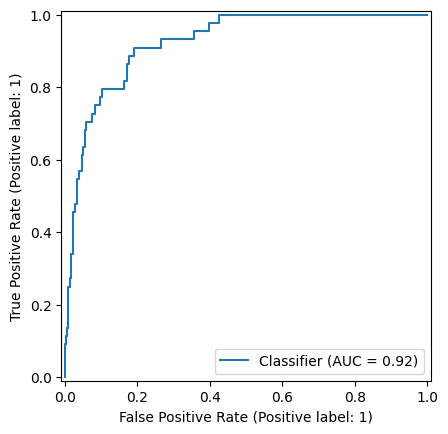

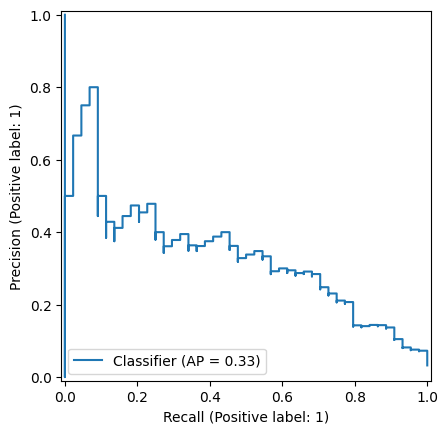

In [5]:

# Calculate balanced class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight = {c:w for c,w in zip(classes, weights)}

logreg = Pipeline([('prep', preprocessor),
                   ('model', LogisticRegression(max_iter=1000, class_weight=class_weight, solver='lbfgs'))])
grid = {'model__C':[0.1, 1, 10]}
log_cv = GridSearchCV(logreg, grid, scoring='roc_auc', cv=5, n_jobs=-1)
log_cv.fit(X_train, y_train)
log_best = log_cv.best_estimator_
print('Best params:', log_cv.best_params_)

y_pred = log_best.predict(X_test)
y_prob = log_best.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, digits=3))
print('ROC-AUC:', round(roc_auc_score(y_test, y_prob), 3))
RocCurveDisplay.from_predictions(y_test, y_prob); plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_prob); plt.show()


## Model 2 — Random Forest Classifier (with class_weight='balanced')

Best params: {'model__max_depth': 12, 'model__min_samples_split': 5, 'model__n_estimators': 700}
              precision    recall  f1-score   support

           0      0.982     0.973     0.978      1320
           1      0.375     0.477     0.420        44

    accuracy                          0.957      1364
   macro avg      0.679     0.725     0.699      1364
weighted avg      0.963     0.957     0.960      1364

ROC-AUC: 0.944


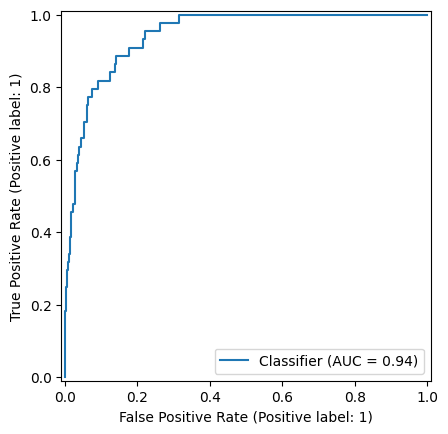

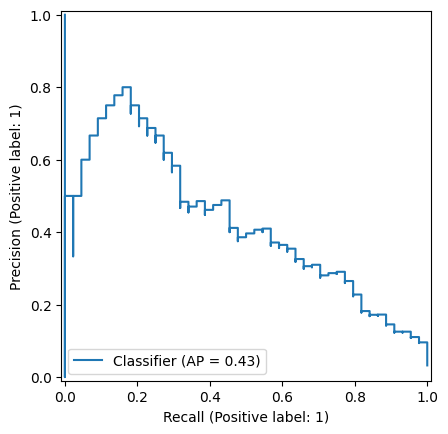

In [6]:

rf = Pipeline([('prep', preprocessor),
               ('model', RandomForestClassifier(class_weight='balanced', random_state=42))])
grid = {'model__n_estimators':[400, 700],
        'model__max_depth':[None, 12, 20],
        'model__min_samples_split':[2, 5]}
rf_cv = GridSearchCV(rf, grid, scoring='roc_auc', cv=5, n_jobs=-1)
rf_cv.fit(X_train, y_train)
rf_best = rf_cv.best_estimator_
print('Best params:', rf_cv.best_params_)

y_pred = rf_best.predict(X_test)
y_prob = rf_best.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, digits=3))
print('ROC-AUC:', round(roc_auc_score(y_test, y_prob), 3))
RocCurveDisplay.from_predictions(y_test, y_prob); plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_prob); plt.show()


## Confusion Matrices

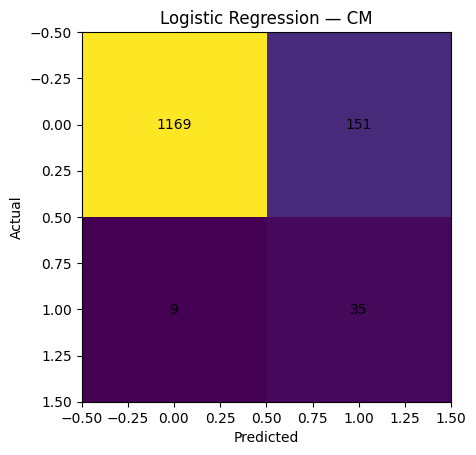

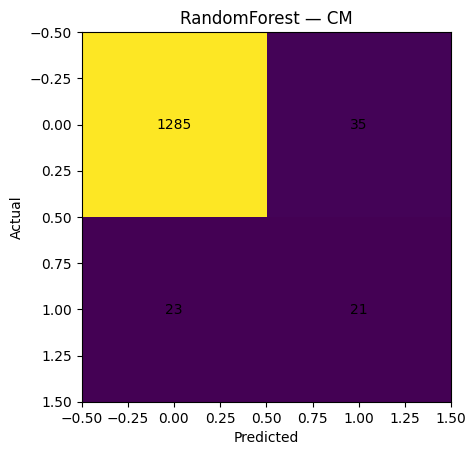

In [7]:

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel('Predicted'); ax.set_ylabel('Actual')
    for (i,j), z in np.ndenumerate(cm):
        ax.text(j, i, str(z), ha='center', va='center')
    plt.show()

plot_cm(y_test, log_best.predict(X_test), 'Logistic Regression — CM')
plot_cm(y_test, rf_best.predict(X_test), 'RandomForest — CM')


## Feature Importance (RF) & Save outputs

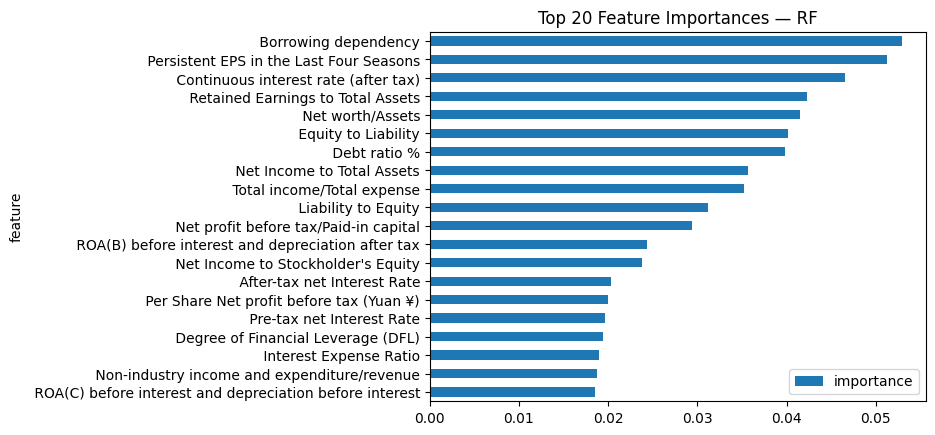

,y_true,logreg_pred,rf_pred
1244,0,0,0
6303,0,0,0
4712,0,0,0
3273,0,0,0
6430,0,0,0


In [8]:

# Feature names after one-hot
ohe = rf_best.named_steps['prep'].named_transformers_['cat'].named_steps.get('onehot', None)
cat_names = ohe.get_feature_names_out(categorical_cols) if (ohe is not None and len(categorical_cols)) else []
feature_names = list(numeric_cols) + list(cat_names)

importances = rf_best.named_steps['model'].feature_importances_
fi = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(20)
fi.plot(kind='barh', x='feature', y='importance'); plt.gca().invert_yaxis(); plt.title('Top 20 Feature Importances — RF'); plt.show()
fi.to_csv(Path('../reports/feature_importance_bankruptcy.csv'), index=False)

out = pd.DataFrame({'y_true': y_test,
                    'logreg_pred': log_best.predict(X_test),
                    'rf_pred': rf_best.predict(X_test)})
out.to_csv(Path('../reports/bankruptcy_predictions.csv'), index=False)
out.head()
